In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import time
from torch_geometric.data import Data
import numpy.linalg as LA
import networkx as nx
from torch_geometric.utils import to_networkx
from torchsummary import summary

if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using GPU device: GeForce RTX 2080 Ti


In [6]:
from torch_geometric.utils import grid
import time

def load_and_transform(train_batch, test_batch, dataset):
    start1 = time.time()
    if dataset=='mnist':
        mnist_train=datasets.MNIST('data', download=True, train=True)
        train_X=mnist_train.train_data/256
        train_y=mnist_train.targets
        mnist_test=datasets.MNIST('data', download=True, train=False)
        test_X=mnist_test.test_data/256
        test_y=mnist_test.targets
        N=28
        in_channel=1
        g=grid(N,N)
        
    if dataset=='cifar':
        cifar_train = datasets.CIFAR10('data',  train=True, download=True)
        train_X= torch.tensor(cifar_train.data/256)
        train_y=torch.tensor(cifar_train.targets)
        cifar_test = datasets.CIFAR10('data', train=False,download=True)
        test_X=torch.tensor(cifar_test.data/256)
        test_y=torch.tensor(cifar_test.targets)
        N=32
        in_channel=3
        g=grid(N,N)
            
    train_list =[]
    test_list=[]
    train_size=train_X.size(0)
    test_size=test_X.size(0)
    transform = T.Cartesian(cat=False)
    for i in range(train_size):
        train_list.append(transform(Data(x=train_X[i].view(N*N,in_channel).float(),y=train_y[i], edge_index=g[0],pos=g[1])))
        if i<test_size:
            test_list.append(transform(Data(x=test_X[i].view(N*N,in_channel).float(),y=test_y[i], edge_index=g[0],pos=g[1])))
    
    train_loader = DataLoader(train_list, batch_size=train_batch)
    test_loader = DataLoader(test_list, batch_size=test_batch)
    end1 = time.time()
    print("loading time: "+ str(end1 - start1))
    return train_loader, test_loader

In [153]:
#mnist
train_mnist, test_mnist=load_and_transform(100, 100, 'mnist')
#cifar
train_cifar, test_cifar=load_and_transform(100, 100, 'cifar')


loading time: 32.607195138931274
Files already downloaded and verified
Files already downloaded and verified
loading time: 39.137128829956055


In [165]:
class Spline(torch.nn.Module):
    def __init__(self,in_c,N):
        super().__init__()
        self.conv1 = SplineConv(in_c, 16, dim=2, kernel_size=6)
        self.fc1 = torch.nn.Linear(N*N*16, 10)
        self.N = N

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index, data.edge_attr))
        x=x.view(100,self.N*self.N*16)
        x =self.fc1(x)
        return x

In [143]:
def accuracy(pred, target):
        pred=pred.max(axis=1)[1]
        corrects = 100.0 *torch.eq(pred, target).sum().float() / len(target)
        return corrects.item()
    
def plot_history(history):
    fig = plt.figure(figsize=(15, 5))

    # Plot the loss history
    f1 = fig.add_subplot(121)
    plt.title('Loss')
    plt.plot(history['train_loss'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()

    # Plot the accuracy history
    f2 = fig.add_subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history['train_accuracy'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()
    
    plt.show()

In [147]:
def training_loop(EPOCHS, MODEL, OPTIMIZER, device, train_loader, test_loader):
    summary(MODEL)
    
    if torch.cuda.is_available() is False:
        raise Exception("GPU device not found, runtime environment should be set to GPU")
    print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    
    
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': [], 'epoch_loss':
              [], 'epoch_accuracy':[],'time':None}
    
   
    for epoch in range(EPOCHS):
        start=time.time()
        train_loss = []
        train_acc = []
        test_loss = 0
        test_acc = 0
        for step, data in enumerate(train_loader):
            data.to(device)
            OPTIMIZER.zero_grad()  # Clear gradients.
            y_out = MODEL(data) # Perform a single forward pass.
            loss = criterion(y_out, data.y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            OPTIMIZER.step()  # Update parameters based on gradients.
            train_loss.append(loss.detach().item())
            train_acc.append(accuracy(y_out, data.y))
            
        epoch_loss=float("{:.2f}".format(sum(train_loss)/(step+1)))
        epoch_acc=float("{:.2f}".format(sum(train_acc)/(step+1)))
        
        for step,data in enumerate(test_loader):
            data.to(device)
            y_out =MODEL(data)
            loss = criterion(y_out,  data.y) 
            test_loss += loss.detach().item()
            test_acc += accuracy(y_out, data.y)
        test_loss = test_loss / (step+1)
        test_acc = test_acc / (step+1)
        end=time.time()
        print(f"Epoch: {epoch} | Train loss: {epoch_loss} | Train accuracy: {epoch_acc}  | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_acc)
        history['time']=end-start
    return history

In [150]:
#MNIST
device = torch.cuda.current_device()
MODEL_Spline=Spline(1,28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Spline.parameters(), lr=0.03)   
EPOCHS = 1

history = training_loop(EPOCHS, MODEL_Spline, OPTIMIZER, device,train_mnist, test_mnist )

Layer (type:depth-idx)                   Param #
├─SplineConv: 1-1                        270
├─Linear: 1-2                            78,410
Total params: 78,680
Trainable params: 78,680
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 0.25 | Train accuracy: 92.69  | Test loss: 0.12224893037928268 | Test accuracy: 96.26| Time: 15.246772050857544


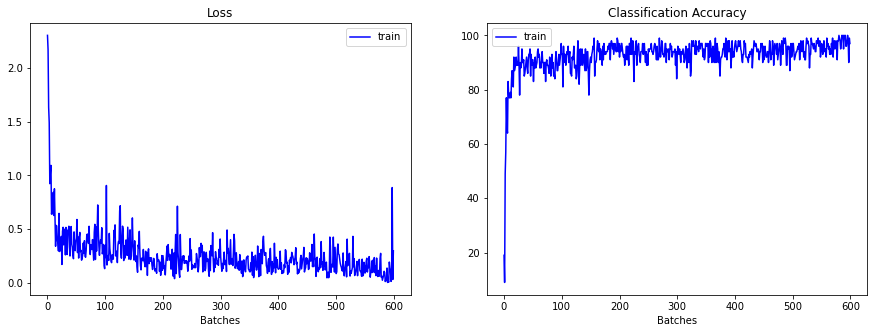

In [154]:
plot_history(history)

In [167]:
#CIFAR
device = torch.cuda.current_device()
MODEL_Spline1=Spline(3,32).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Spline1.parameters(), lr=0.003)   
EPOCHS = 10

history1 = training_loop(EPOCHS, MODEL_Spline1, OPTIMIZER, device,train_cifar, test_cifar)

Layer (type:depth-idx)                   Param #
├─SplineConv: 1-1                        1,792
├─Linear: 1-2                            163,850
Total params: 165,642
Trainable params: 165,642
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 1.69 | Train accuracy: 40.89  | Test loss: 1.499349775314331 | Test accuracy: 48.02| Time: 16.267632246017456
Epoch: 1 | Train loss: 1.43 | Train accuracy: 49.9  | Test loss: 1.4033837795257569 | Test accuracy: 50.64| Time: 15.409473896026611
Epoch: 2 | Train loss: 1.33 | Train accuracy: 53.75  | Test loss: 1.3749332630634308 | Test accuracy: 51.66| Time: 15.2690110206604
Epoch: 3 | Train loss: 1.25 | Train accuracy: 56.4  | Test loss: 1.333585605621338 | Test accuracy: 53.73| Time: 16.104981899261475
Epoch: 4 | Train loss: 1.18 | Train accuracy: 58.89  | Test loss: 1.3307510995864869 | Test accuracy: 53.89| Time: 15.379649639129639
Epoch: 5 | Train loss: 1.13 | Train accuracy: 60.8  | Test loss: 1.31604555606842

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import pygsp as pygsp

In [76]:
mnist_train=datasets.MNIST('data', download=True, train=True)
train_X=mnist_train.train_data/256
data=train_X[0]
data=data.view(-1).numpy()
G=graphs.Grid2d(28,28)

/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


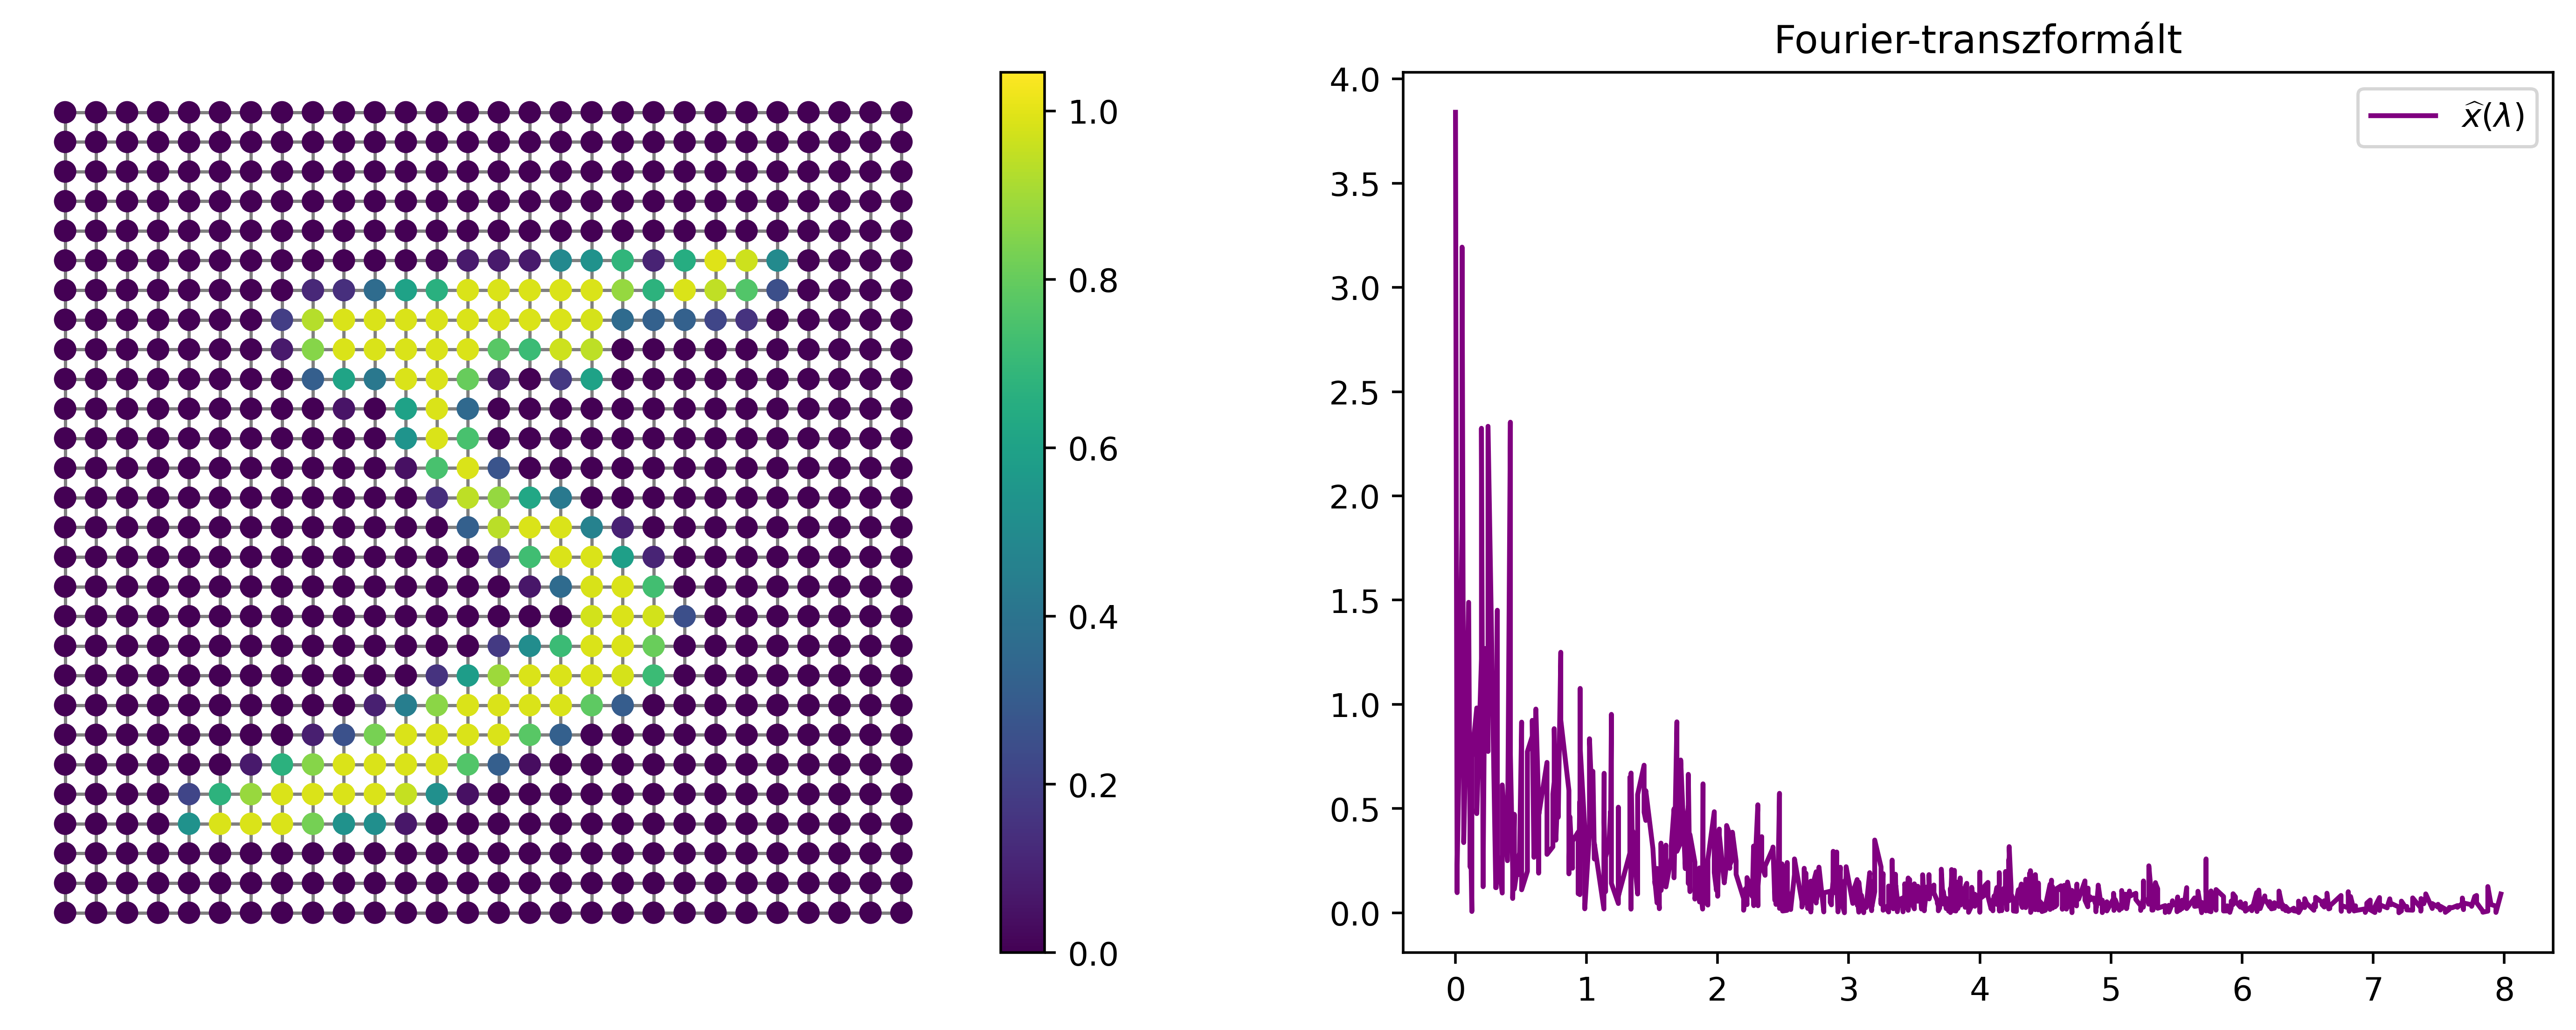

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5),dpi=500)
G.plot_signal(data,ax=axes[0],vertex_size=35)
axes[0].set_title('')
axes[1].set_title('Fourier-transzformált')
axes[0].set_axis_off()

x_hat = G.gft(data).squeeze()
axes[1].plot(G.e, np.abs(x_hat), '-',label=r'$\widehat{x}(\lambda)$',color='purple')
axes[1].legend()


In [62]:
G.compute_fourier_basis()

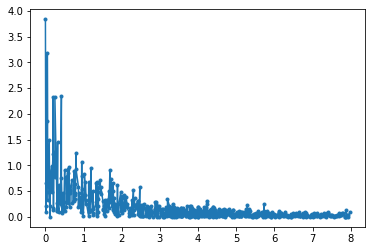

In [70]:
x_hat = G.gft(data).squeeze()
plt.plot(G.e, np.abs(x_hat), '.-',label=r'$\widehat{x}(\lambda)$')

In [103]:
!pwd

/home/harsanyi
